# Implementing PID Control in Nonlinear Simulaitons

This notebook demonstrates the simulation of PID for an exothermic stirred tank reactor where the objective is to control the reactor temperature through manipulation of cooling water through the reactor cooling jacket.

## Model

In [119]:
# import necessary library
import warnings
warnings.filterwarnings("ignore") # close warining
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import seaborn as sns
sns.set_context('talk')

In [120]:
# parameter for model
Ea  = 72750    # activation energy J/gmol
R   = 8.314    # gas constant J/gmol/K
k0  = 7.2e10   # Arrhenius rate constant 1/min
V   = 100.0    # Volume L
rho = 1000.0   # Density g/L
Cp  = 0.239    # Heat capacity J/g/K
dHr = -5.0e4   # Enthalpy of reaction J/mol
UA  = 5.0e4    # Heat transfer J/min/K
q   = 100.0    # Flowrate L/min
Cf  = 1.0      # Inlet feed concentration mol/L
Tf  = 300.0    # Inlet feed temperature K
C0  = 0.5      # Initial concentration mol/L
T0  = 350      # Coolant feed temperature K
Tcf = 300.0    # Coolant feed temperature K
qc  = 50.0     # Nominal coolant flowrate L/min
Vc  = 20.0     # Cooling jacket volume

In [121]:
# from arrhenius rate expression
def k(T):
    r = k0*np.exp(-Ea/(R*T))
    return r

In [122]:
# differential equation
def deriv(X, t):
    C, T, Tc = X # example. X = [0,0,0]
    dC = (q/V)*(Cf-C)-k(T)*C # conc reactor
    dT = (q/V)*(Tf-T)+(-dHr/rho/Cp)*k(T)*C+(UA/V/rho/Cp)*(Tc-T) # temp reactor
    dTc = (qc/Vc)*(Tcf-Tc)+(UA/Vc/rho/Cp)*(T-Tc)# temp coolant
    return [dC, dT, dTc]

In [123]:
# Visualization
def plotReactor(t, X):
    plt.subplot(1, 2, 1) # one-row two-graph num1-graph
    plt.plot(t, X[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('gmol/liter')
    plt.title('Reactor Concentration [mol/L]')
    plt.ylim(0,1)
    plt.grid()
    
    plt.subplot(1, 2, 2) # one-row two-graph num2-graph
    plt.plot(t, X[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Kelvin [K]')
    plt.title('Reactor Temperature [K]')
    plt.ylim(300, 520)
    plt.grid()

### 1.The actual simulation

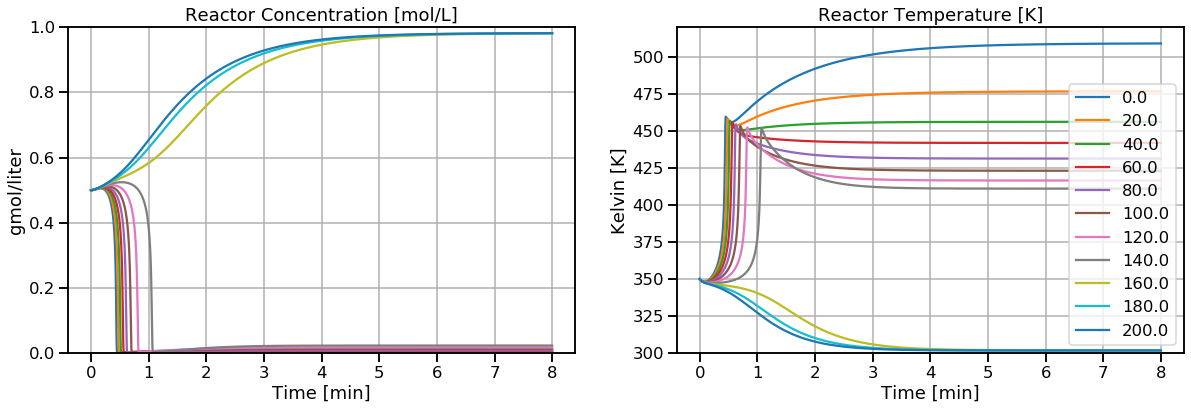

In [124]:
#from parameter
C0  = 0.5      # Initial concentration mol/L
T0  = 350      # Coolant feed temperature K
Tcf = 300.0    # Coolant feed temperature K
# bound condition
IC  = [C0, T0, Tcf]
t   = np.linspace(0, 8.0, 2000) # simulation time grid
qList = np.linspace(0, 200, 11)

plt.figure(figsize=(20,6))  # setup figure
for qc in qList: # for each flowrate q_c
    X = odeint(deriv, IC, t) # preform simulation
    plotReactor(t,X) # plot the results
    
plt.legend(qList)
plt.show()

The results clearly show a strongly nonlinear behavior for cooling water flowrates in the range from 140 to 160 liters per minute. Here we expand on that range to better understand what is going on.

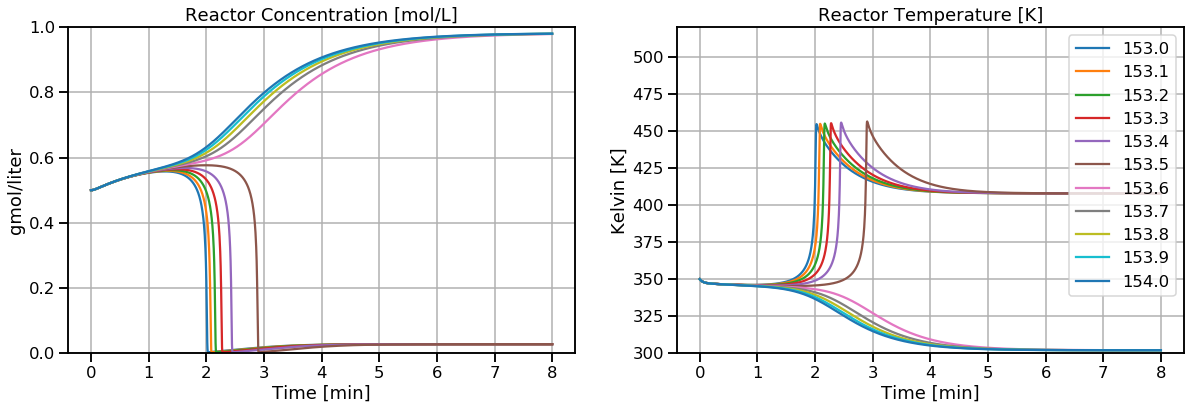

In [125]:
# set qList = np.linspace(153,154,11) forcus
IC = [C0, T0, Tcf]
t = np.linspace(0, 8.0, 2000) # simulation time grid

qList = np.linspace(153, 154, 11)

plt.figure(figsize=(20,6)) # setup figure
for qc in qList:
    X = odeint(deriv, IC, t) # perform simulation
    plotReactor(t,X) #plot the results
    
plt.legend(qList)
plt.show()

There's a clear bifurcation when operated without feedback control. At cooling flowrates less than 153.7 liters/minute, the reactor goes to a high conversion steady state with greater than 95% conversion and a reactor temperature higher than about 410K. Coolant flowrates less than 153.8 liters/minute result in uneconomic operation at low conversion.

For the remainder of this notebook, our objective will be to achieve stable operation of the reactor at a high conversion steady state but with an operating temperature below 400 K, an operating condition that does not appear to be possible without feedback control.

### 2.Fixed Time Grid

In [126]:
#set initial conditions and cooling flow
IC = [C0, T0, Tcf]

# do simulation at fixed time steps dt
dt = 0.05        # time frame = 0.05 min
ti = 0.0         # initial time = 0.0 min
tf = 8.0         # final time = 8.0 min

# create pyhon list to log results
log = []

# start simulation
c, T, Tc = IC
qc = 153.8 # cooling wate flowrate 
for t in np.linspace(ti, tf, int((tf-ti)/dt)+1):
    log.append([t, c, T, Tc, qc])                  # log data for later plotting
    c, T, Tc = odeint(deriv, [c,T,Tc], [t, t+dt])[-1] # start at t, find state at t+dt
    

[8.0, 0.07153996074749257, 390.00011687425, 340.1741607396426, 259.46641059228045]


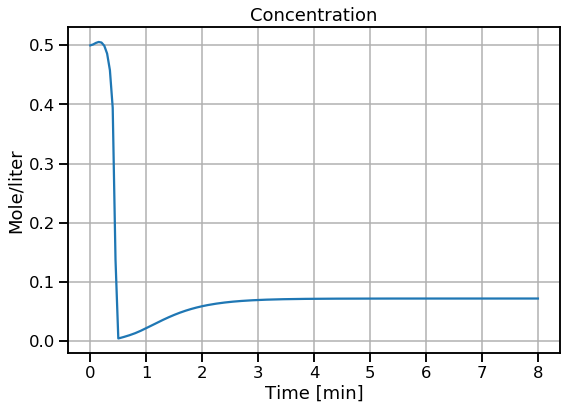

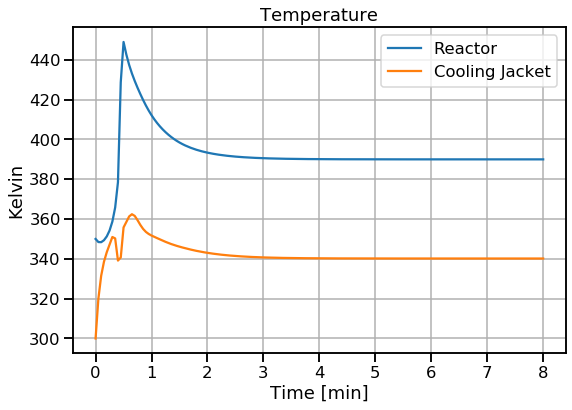

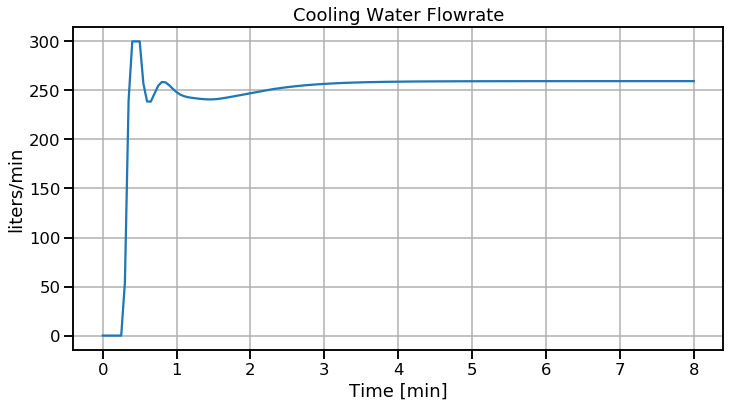

In [138]:
#function for plot q
def qplot(log):
    #print('log1:',log)
    log = np.asarray(log).T # transpose
    #print('log2:',log)
    plt.figure(figsize=(30,6))
    plt.subplot(1, 3, 1)
    plt.plot(log[0], log[1])
    plt.title('Concentration')
    plt.ylabel('Mole/liter')
    plt.xlabel('Time [min]')
    plt.grid()
    
    plt.figure(figsize=(30,6))
    plt.subplot(1, 3, 2)
    plt.plot(log[0], log[2])
    plt.plot(log[0], log[3])
    plt.legend(['Reactor', 'Cooling Jacket'])
    plt.title('Temperature')
    plt.ylabel('Kelvin')
    plt.xlabel('Time [min]')
    plt.grid()
    
    plt.figure(figsize=(30,6))
    plt.subplot(1, 3, 3)
    plt.plot(log[0], log[4])
    plt.title('Cooling Water Flowrate')
    plt.ylabel('liters/min')
    plt.xlabel('Time [min]')
    plt.grid()
    
    plt.tight_layout()
   
    
SS = log[-1] # last log at steadt state
print(SS)
qplot(log)
    

### 3.Proportional-Integral-Derivative Control implement

PID types : Independent Parameters + Setpoint Weighting + Discrete Time Implementation + Bounded Control

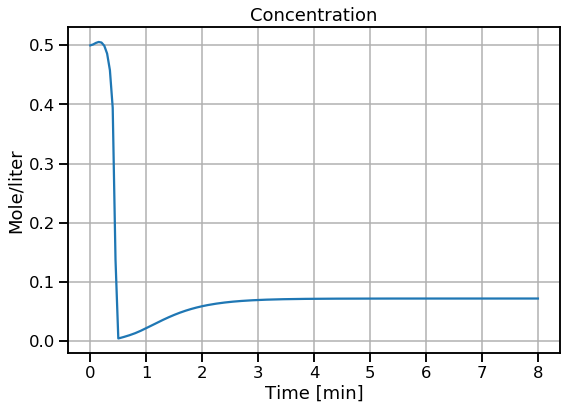

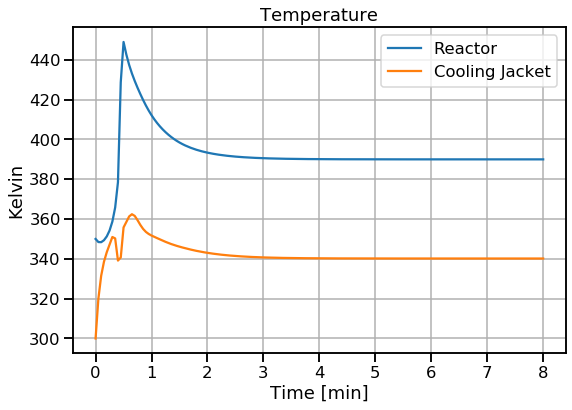

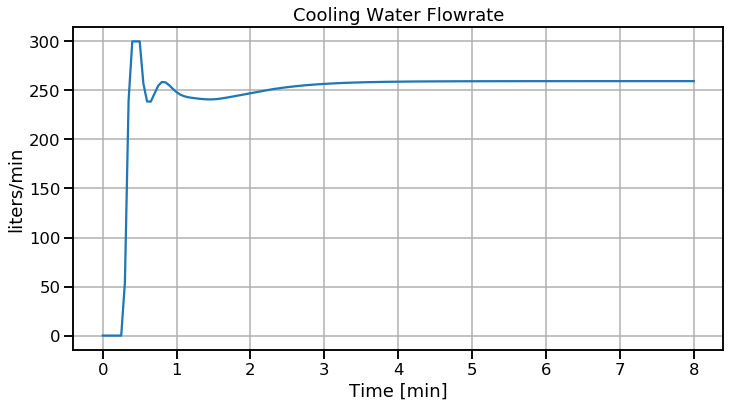

In [147]:
# Setpoint
Tsp = 390 # temp set point degree C

# set initial conditions and cooling flow
IC = [C0, T0, Tcf]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# control satuation
qc_min = 0 # minimum possible coolant flowrate
qc_max = 300 # maximum possible coolant flowrate
def sat(qc):
    max_qc = max(qc_min, min(qc_max,qc)) # if qc>300 max_qc = qc_max
    return max_qc

# control hyperparameters
Kp = 40
Ki = 80
Kd = 0
beta = 0
gamma = 0

# create python list to log results
log = []

# start simulation
c, T, Tc = IC
qc = 150 # cooling water flowrate

eP_  = beta*Tsp-T        # beta*SP-PV
eD_  = gamma*Tsp - T
eD__ = eD_

# PID controller calculation
for t in np.linspace(ti, tf, int((tf-ti)/dt)+1):
    eP = beta*Tsp-T
    eI = Tsp - T
    eD = gamma*Tsp - T
    P = Kp*(eP-eP_)
    I = Ki*dt*eI
    D = Kd*(eD-2*eD_+eD__)/dt
    qc -= P+I+D
    qc = sat(qc)
    
    # log data and update state
    log.append([t, c, T, Tc, qc])
    c, T, Tc = odeint(deriv,[c, T, Tc], [t, t+dt])[-1]
    
    # save data for pid calculations
    eD__, eD_, eP_ = eD_, eD, eP

qplot(log)


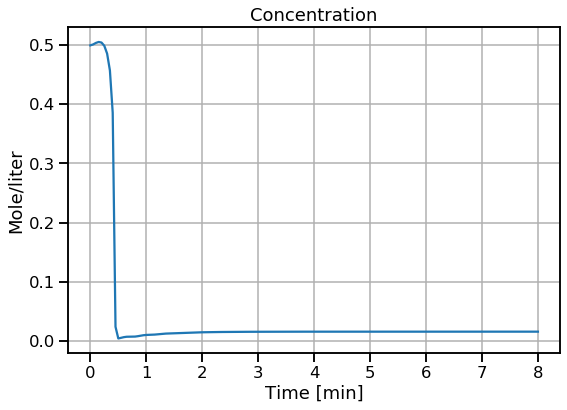

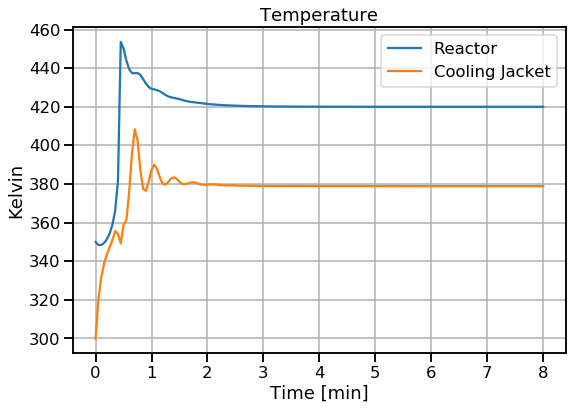

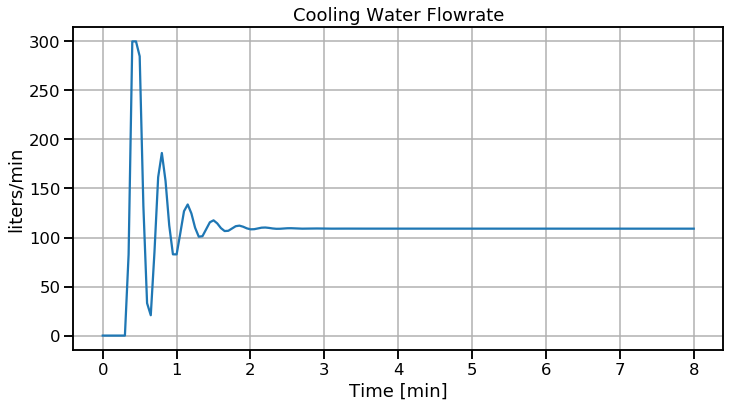

In [148]:
# Setpoint
Tsp = 420 # temp set point degree C

# set initial conditions and cooling flow
IC = [C0, T0, Tcf]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 8.0

# control satuation
qc_min = 0 # minimum possible coolant flowrate
qc_max = 300 # maximum possible coolant flowrate
def sat(qc):
    max_qc = max(qc_min, min(qc_max,qc)) # if qc>300 max_qc = qc_max
    return max_qc

# control hyperparameters
Kp = 40
Ki = 80
Kd = 0
beta = 0
gamma = 0

# create python list to log results
log = []

# start simulation
c, T, Tc = IC
qc = 150 # cooling water flowrate

eP_  = beta*Tsp-T        # beta*SP-PV
eD_  = gamma*Tsp - T
eD__ = eD_

# PID controller calculation
for t in np.linspace(ti, tf, int((tf-ti)/dt)+1):
    eP = beta*Tsp-T
    eI = Tsp - T
    eD = gamma*Tsp - T
    P = Kp*(eP-eP_)
    I = Ki*dt*eI
    D = Kd*(eD-2*eD_+eD__)/dt
    qc -= P+I+D
    qc = sat(qc)
    
    # log data and update state
    log.append([t, c, T, Tc, qc])
    c, T, Tc = odeint(deriv,[c, T, Tc], [t, t+dt])[-1]
    
    # save data for pid calculations
    eD__, eD_, eP_ = eD_, eD, eP

qplot(log)
